2016-06-30 00:00:00
rebalancing weights: {'099140.KS': 0.0982, '102110.KS': 0.1041, '114460.KS': 0.1001, '122260.KS': 0.2001, '148070.KS': 0.0999, '195980.KS': 0.101, '203780.KS': 0.0966, '214980.KS': 0.2}
2016-07-01 00:00:00
make re-allocation {'099140.KS': 0.0982, '102110.KS': 0.1041, '114460.KS': 0.1001, '122260.KS': 0.2001, '148070.KS': 0.0999, '195980.KS': 0.101, '203780.KS': 0.0966, '214980.KS': 0.2}
rebalancing weights: {}
2016-07-02 00:00:00
rebalancing weights: {}
2016-07-03 00:00:00
rebalancing weights: {}
2016-07-04 00:00:00
update book values
rebalancing weights: {}
2016-07-05 00:00:00
update book values
rebalancing weights: {}
2016-07-06 00:00:00
update book values
rebalancing weights: {}
2016-07-07 00:00:00
update book values
rebalancing weights: {}
2016-07-08 00:00:00
update book values
rebalancing weights: {}
2016-07-09 00:00:00
rebalancing weights: {}
2016-07-10 00:00:00
rebalancing weights: {}
2016-07-11 00:00:00
update book values
rebalancing weights: {}
2016-07-12 0

<AxesSubplot:>

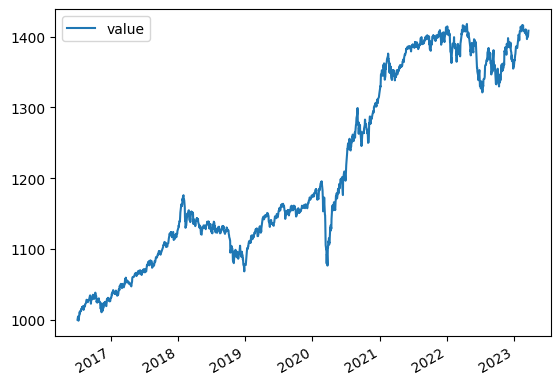

In [38]:
""" base strategy class """

import warnings
from typing import Any, List, Optional, Dict
import numpy as np
import pandas as pd


class Account:
    """strategy account"""

    def __init__(self):
        self.date: List = []
        self.value: List = []
        self.weights: List[Dict] = []
        self.reb_weights: List[Dict] = []
        self.trade_weights: List[Dict] = []


class BaseStrategy:
    """
    BaseStrategy class is an algorithmic trading strategy that sequentially allocates capital among
    group of assets based on pre-defined allocatioin method.

    BaseStrategy shall be the parent class for all investment strategies with period-wise
    rebalancing scheme.

    Using this class requires following pre-defined methods:
    1. rebalance(self, price_asset, date, **kwargs):
        the method shall be in charge of calculating new weights based on prices
        that are avaiable.
    2. monitor (self, ...):
        the method shall be in charge of monitoring the strategy status, and if
        necessary call the rebalance method to re-calculate weights. aka irregular rebalancing.
    """

    def __init__(
        self,
        price_asset: pd.DataFrame,
        frequency: str = "M",
        min_assets: int = 2,
        min_periods: int = 2,
        investment: float = 1000.0,
        commission: int = 0,
        currency: str = "KRW",
        name: str = "strategy",
        account: Optional[Account] = None,
    ) -> None:
        """Initialization"""
        self.price_asset: pd.DataFrame = self.check_price_df(price_asset)
        self.frequency: str = frequency
        self.min_assets: int = min_assets
        self.min_periods: int = min_periods
        self.name: str = name
        self.commission = commission
        self.currency = currency

        # account information
        self.idx: int = 0
        self.date: Any = None
        self.value: float = investment
        self.weights: pd.Series = pd.Series(dtype=float)
        self.reb_weights: pd.Series = pd.Series(dtype=float)
        self.trade_weights: pd.Series = pd.Series(dtype=float)
        self.account: Account = account or Account()

    ################################################################################################
    @property
    def value_df(self):
        """values dataframe"""
        return pd.DataFrame(
            data=self.account.value, index=self.account.date, columns=["value"]
        )

    @property
    def weights_df(self):
        """weights dataframe"""
        return pd.DataFrame(data=self.account.weights, index=self.account.date)

    @property
    def reb_weights_df(self):
        """weights dataframe"""
        return pd.DataFrame(data=self.account.reb_weights, index=self.account.date)

    @property
    def trade_weights_df(self):
        """weights dataframe"""
        return pd.DataFrame(data=self.account.trade_weights, index=self.account.date)

    ################################################################################################

    def update_book(self) -> None:
        """update the account value based on the current date"""
        prices = self.price_asset.loc[self.date]
        if not self.weights.empty:
            print(f"update book values")
            pre_prices = self.price_asset.iloc[
                self.price_asset.index.get_loc(self.date) - 1
            ]
            capitals = self.weights * self.value
            pri_return = prices / pre_prices
            new_capitals = capitals * pri_return.loc[capitals.index]
            profit_loss = new_capitals - capitals
            self.value += profit_loss.sum()
            self.weights = new_capitals / self.value

        if not self.reb_weights.empty:
            print(f"make re-allocation {self.reb_weights.to_dict()}")
            # reindex to contain the same asset.
            union_assets = self.reb_weights.index.union(self.weights.index)
            self.weights = self.weights.reindex(union_assets, fill_value=0)
            self.reb_weights = self.reb_weights.reindex(union_assets, fill_value=0)
            self.trade_weights = self.reb_weights.subtract(self.weights)
            trade_capitals = self.value * self.trade_weights
            trade_costs = trade_capitals.abs() * self.commission / 10_000
            trade_cost = trade_costs.sum()
            # update the account metrics.
            self.value -= trade_cost
            self.weights = self.reb_weights

        # do nothing if no account data.
        if self.weights.empty and self.reb_weights.empty:
            return
        # loop through all variables in account history
        for name in vars(self.account).keys():
            getattr(self.account, name).append(getattr(self, name))
        # clear the rebalancing weights.
        self.reb_weights = pd.Series(dtype=float)
        self.trade_weights = pd.Series(dtype=float)

    ################################################################################################

    def simulate(self, start: ... = None, end: ... = None) -> ...:
        """simulate historical strategy perfromance"""
        start = start or self.price_asset.index[0]
        end = end or self.price_asset.index[-1]
        reb_dates = pd.date_range(start=start, end=end, freq=self.frequency)
        for self.date in pd.date_range(start=start, end=end, freq="D"):
            print(self.date)
            if self.date in self.price_asset.index:
                self.update_book()
            if self.weights.empty or self.monitor() or self.date in reb_dates:
                if not self.reb_weights.empty: continue
                self.reb_weights = self.allocate(self.date)
                print(f"rebalancing weights: {self.reb_weights.to_dict()}")
        return self

    def allocate(self, date: ... = None) -> pd.Series:
        """allocate weights based on date if date not provided use latest"""
        # pylint: disable=multiple-statements
        date = date or self.price_asset.index[-1]
        price_slice = self.price_asset.loc[:date].dropna(
            thresh=self.min_periods, axis=1
        )
        if price_slice.empty:
            return pd.Series(dtype=float)
        reb_weights = self.rebalance(price_asset=price_slice)
        if reb_weights is None:
            return pd.Series(dtype=float)
        return self.clean_weights(reb_weights, decimals=4)

    def rebalance(self, price_asset: pd.DataFrame) -> pd.Series:
        """Default rebalancing method"""
        asset = price_asset.columns
        uniform_weight = np.ones(len(asset))
        uniform_weight /= uniform_weight.sum()
        weight = pd.Series(index=asset, data=uniform_weight)
        return weight

    def monitor(self) -> bool:
        """Default monitoring method."""
        return False

    ################################################################################################
    @staticmethod
    def check_price_df(price_df: pd.DataFrame) -> pd.DataFrame:
        """Check the price_df.

        Args:
            price_df (pd.DataFrame): _description_

        Raises:
            TypeError: if price_df is not pd.DataFrame.

        Returns:
            pd.DataFrame: price_df
        """
        if not isinstance(price_df, pd.DataFrame):
            raise TypeError("price_df must be a pd.DataFrame.")
        if not isinstance(price_df.index, pd.DatetimeIndex):
            warnings.warn("converting price_df's index to pd.DatetimeIndex.")
            price_df.index = pd.to_datetime(price_df.index)
        return price_df

    @staticmethod
    def clean_weights(weights: pd.Series, decimals: int = 4) -> pd.Series:
        """Clean weights based on the number decimals and maintain the total of weights.

        Args:
            weights (pd.Series): asset weights.
            decimals (int, optional): number of decimals to be rounded for
                weight. Defaults to 4.

        Returns:
            pd.Series: clean asset weights.
        """
        # clip weight values by minimum and maximum.
        tot_weight = weights.sum().round(4)
        weights = weights.round(decimals=decimals)
        # repeat round and weight calculation.
        for _ in range(10):
            weights = weights / weights.sum() * tot_weight
            weights = weights.round(decimals=decimals)
            if weights.sum() == tot_weight:
                return weights
        # if residual remains after repeated rounding.
        # allocate the the residual weight on the max weight.
        residual = tot_weight - weights.sum()
        # !!! Error may occur when there are two max weights???
        weights[np.argmax(weights)] += np.round(residual, decimals=decimals)
        return weights


####################################################################################################
def backtest(allocation_df: pd.DataFrame, price_df: pd.DataFrame) -> BaseStrategy:
    """provide a backtested strategy.

    Args:
        allocation_df (pd.DataFrame): allocation dataframe.
        price_df (pd.DataFrame): asset price dataframe.

    Returns:
        BaseStrategy: backtested strategy.
    """

    class Backtest(BaseStrategy):
        """backtest class"""

        def rebalance(self, price_asset: pd.DataFrame) -> pd.Series:
            if self.date in allocation_df.index:
                weights = allocation_df.loc[self.date].dropna()
                return weights[weights != 0]
            return pd.Series(dtype=float)

    strategy = Backtest(price_asset=price_df, frequency="D").simulate(
        start=allocation_df.index[0]
    )

    return strategy


path = r"C:\Users\hanti\OneDrive\DWS\ABL_RESULT\MLP_ALLOCATION.xlsx"

import pandas_datareader as pdr

allocation = pd.read_excel(path, "allocation", index_col=[1, 2, 0], parse_dates=True)
allocation = allocation.unstack().unstack()["weights"]

stra = "KR_3"

allo = allocation[stra].dropna(how="all", axis=1)

tickers = ", ".join(allo.columns.tolist())
tickers = tickers.replace(".KS", "")
tickers = (
    tickers
    if isinstance(tickers, (list, set, tuple))
    else tickers.replace(",", " ").upper().split()
)

prices = []
if stra.startswith("KR"):
    for ticker in tickers:
        price = pdr.DataReader(ticker, "naver", start="1990-1-1").astype(float)[
            "Close"
        ]
        price.name = ticker + ".KS"
        prices.append(price)

    prices = pd.concat(prices, axis=1)

    prices.index = pd.to_datetime(prices.index)

result = backtest(allocation_df=allo, price_df=prices)

result.value_df.plot()


In [40]:
result.reb_weights_df.dropna(how="all")

,099140.KS,102110.KS,114460.KS,122260.KS,148070.KS,195980.KS,203780.KS,214980.KS,069500.KS,133690.KS,...,144600.KS,160580.KS,228800.KS,137610.KS,161510.KS,226490.KS,138230.KS,228810.KS,139260.KS,261220.KS
2016-07-01,0.0982,0.1041,0.1001,0.2001,0.0999,0.1010,0.0966,0.2000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-01,0.0971,0.0000,0.1001,0.2001,0.0999,0.0000,0.0000,0.2000,0.1021,0.0998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01,0.0976,0.0000,0.1001,0.1999,0.0999,0.0996,0.0000,0.2000,0.0000,0.1013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-04,0.0989,0.0000,0.1001,0.2000,0.0999,0.1005,0.0979,0.2000,0.0000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01,0.0979,0.0000,0.1000,0.0000,0.0000,0.0996,0.0000,0.2000,0.1014,0.1011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,0.0000,0.0000,0.0000,0.0000,0.0604,0.0000,0.0000,0.4323,0.0465,0.0000,...,0.0,0.0000,0.0687,0.0164,0.0000,0.0,0.0836,0.0601,NaN,NaN
2022-12-01,0.0000,0.0000,0.0000,0.0000,0.0598,0.0000,0.0000,0.4309,0.0446,0.0829,...,0.0,0.0167,0.0000,0.0000,0.0000,0.0,0.0833,0.0000,0.0713,NaN
2023-01-02,0.0000,0.0000,0.0000,0.0000,0.0593,0.0000,0.0000,0.4284,0.0449,0.0827,...,0.0,0.0168,0.0000,0.0000,0.0000,0.0,0.0832,0.0000,0.0715,NaN
2023-02-01,0.0000,0.0000,0.0000,0.0000,0.0167,0.0000,0.0000,0.2240,0.0998,0.0704,...,0.0,0.0197,0.0000,0.0000,0.0000,0.0,0.0803,0.0000,0.0000,NaN
